In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn import svm 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report,roc_auc_score,roc_curve, auc
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings('ignore') 
import sklearn  
import sklearn.ensemble 
from yellowbrick.classifier import DiscriminationThreshold
import plotly.graph_objects as go
from plotly.offline import iplot, init_notebook_mode
import pickle

In [4]:
df = pd.read_csv("bank_churn.csv")

In [5]:
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# Looking at the caracteristics of the columns

In [6]:
# Checking the type and the number of non-null value
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [7]:
# Checking if there is duplicates rows
len(df[df.duplicated()])

0

In [8]:
# Removing irrelevant columns

df = df.drop(['customer_id'], axis = 1)

Text(0, 0.5, 'estimated_salary')

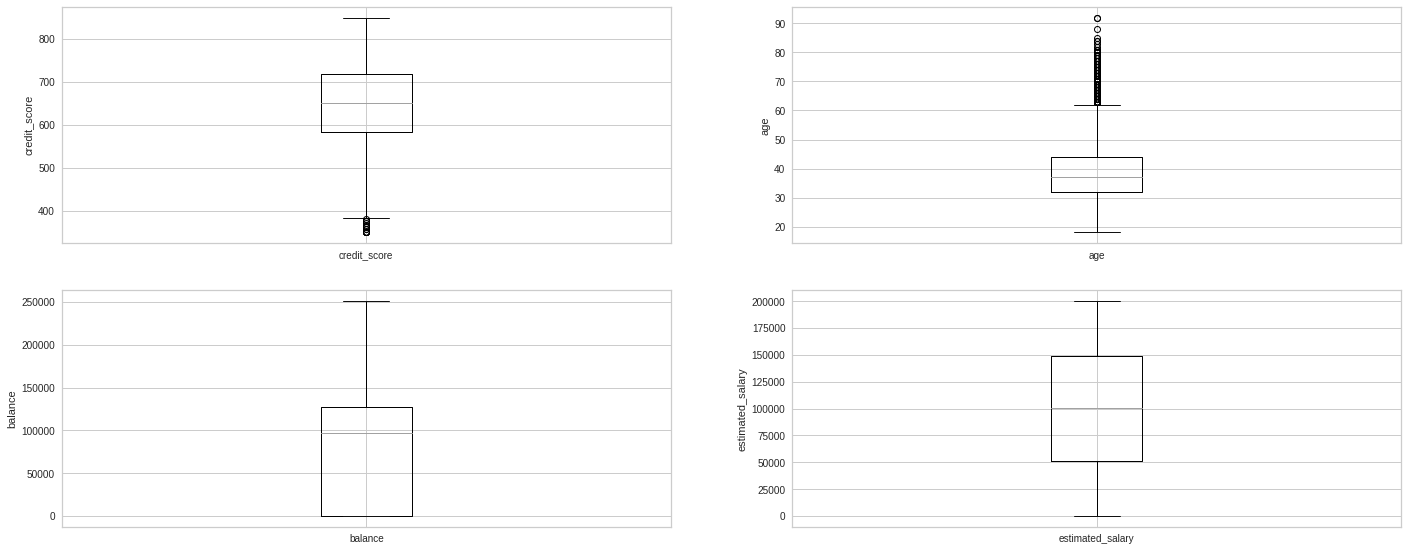

In [9]:
# Dealing with the outliers

plt.figure(figsize=(24,20))


plt.subplot(4, 2, 1)
fig = df.boxplot(column='credit_score')
fig.set_title('')
fig.set_ylabel('credit_score')


plt.subplot(4, 2, 2)
fig = df.boxplot(column='age')
fig.set_title('')
fig.set_ylabel('age')


plt.subplot(4, 2, 3)
fig = df.boxplot(column='balance')
fig.set_title('')
fig.set_ylabel('balance')


plt.subplot(4, 2, 4)
fig = df.boxplot(column='estimated_salary')
fig.set_title('')
fig.set_ylabel('estimated_salary')

In [10]:
IQR= df['credit_score'].quantile(0.75) - df['credit_score'].quantile(0.25)
IQR
## Calculating the boundaries
lower_bridge= df['credit_score'].quantile(0.25)-(IQR*1.5)
upper_bridge= df['credit_score'].quantile(0.75)+(IQR*1.5)

df['credit_score'] = df['credit_score'].clip(lower_bridge,upper_bridge)

IQR= df['age'].quantile(0.75) - df['age'].quantile(0.25)
IQR
## Calculating the boundaries
lower_bridge= df['age'].quantile(0.25)-(IQR*1.5)
upper_bridge= df['age'].quantile(0.75)+(IQR*1.5)

df['age'] = df['age'].clip(lower_bridge,upper_bridge)

IQR= df['balance'].quantile(0.75) - df['balance'].quantile(0.25)
IQR
## Calculating the boundaries
lower_bridge= df['balance'].quantile(0.25)-(IQR*1.5)
upper_bridge= df['balance'].quantile(0.75)+(IQR*1.5)

df['balance'] = df['balance'].clip(lower_bridge,upper_bridge)

IQR= df['estimated_salary'].quantile(0.75) - df['estimated_salary'].quantile(0.25)
IQR
## Calculating the boundaries
lower_bridge= df['estimated_salary'].quantile(0.25)-(IQR*1.5)
upper_bridge= df['estimated_salary'].quantile(0.75)+(IQR*1.5)

df['estimated_salary'] = df['estimated_salary'].clip(lower_bridge,upper_bridge)

# Data exploration and vizualisation


In [11]:
# Count of target variable 

df["churn"].value_counts()


0    7963
1    2037
Name: churn, dtype: int64

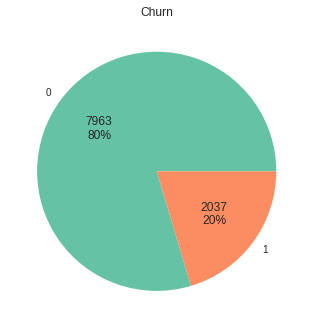

In [12]:
def label_function(val):
    return f'{val / 100 * len(df):.0f}\n{val:.0f}%'
    
colors = sns.color_palette('Set2')
plot = df.groupby('churn').size().plot(kind='pie', autopct=label_function, colors=colors,title = 'Churn').set(ylabel = "")

In [13]:
# checking descriptive statistics for numerical columns
df.loc[:, ~df.columns.isin(['churn','products_number', 'credit_card', 'active_member'])].describe()

,credit_score,age,tenure,balance,estimated_salary
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.561300,38.660800,5.012800,76485.889288,100090.239881
std,96.558702,9.746704,2.892174,62397.405202,57510.492818
min,383.000000,18.000000,0.000000,0.000000,11.580000
25%,584.000000,32.000000,3.000000,0.000000,51002.110000
50%,652.000000,37.000000,5.000000,97198.540000,100193.915000
75%,718.000000,44.000000,7.000000,127644.240000,149388.247500
max,850.000000,62.000000,10.000000,250898.090000,199992.480000


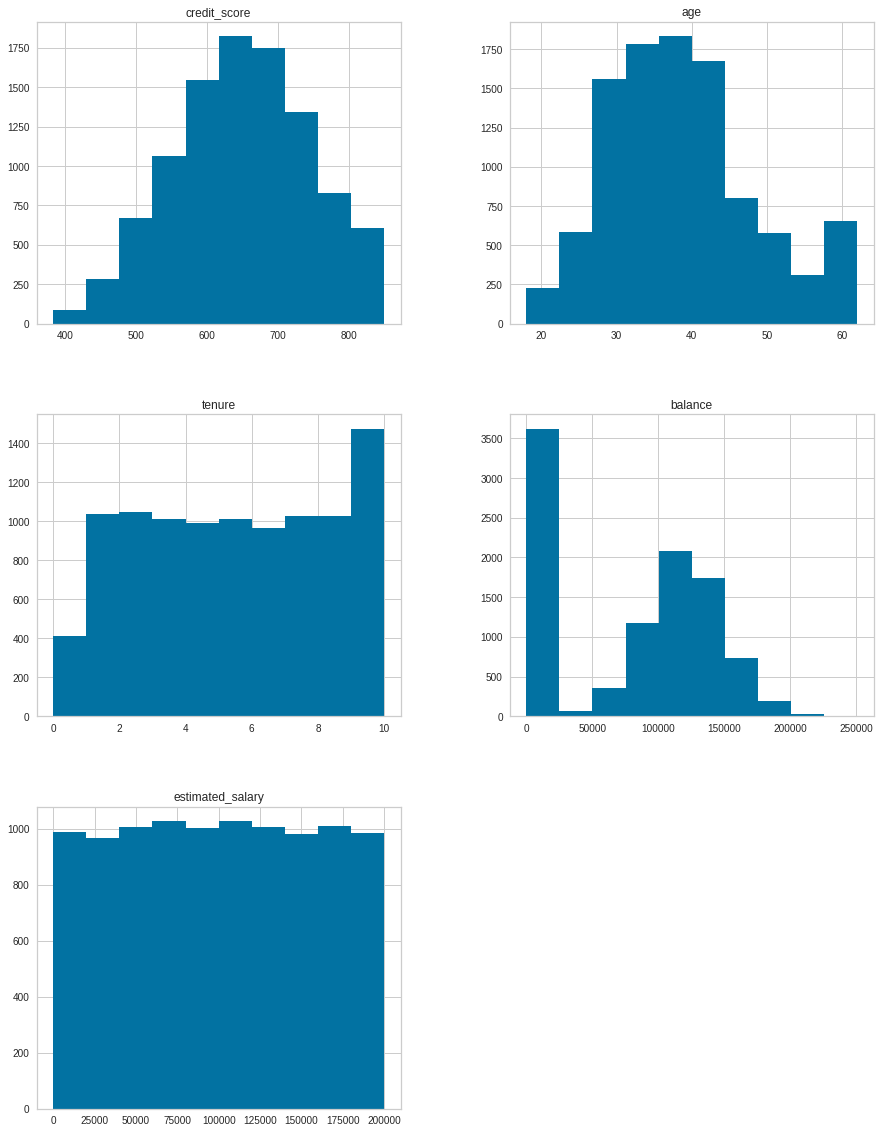

In [14]:
#histogram of all columns to see distribution 
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df.loc[:, ~df.columns.isin(['churn','products_number', 'credit_card', 'active_member'])].hist(ax=ax)
plt.savefig('Histogram')

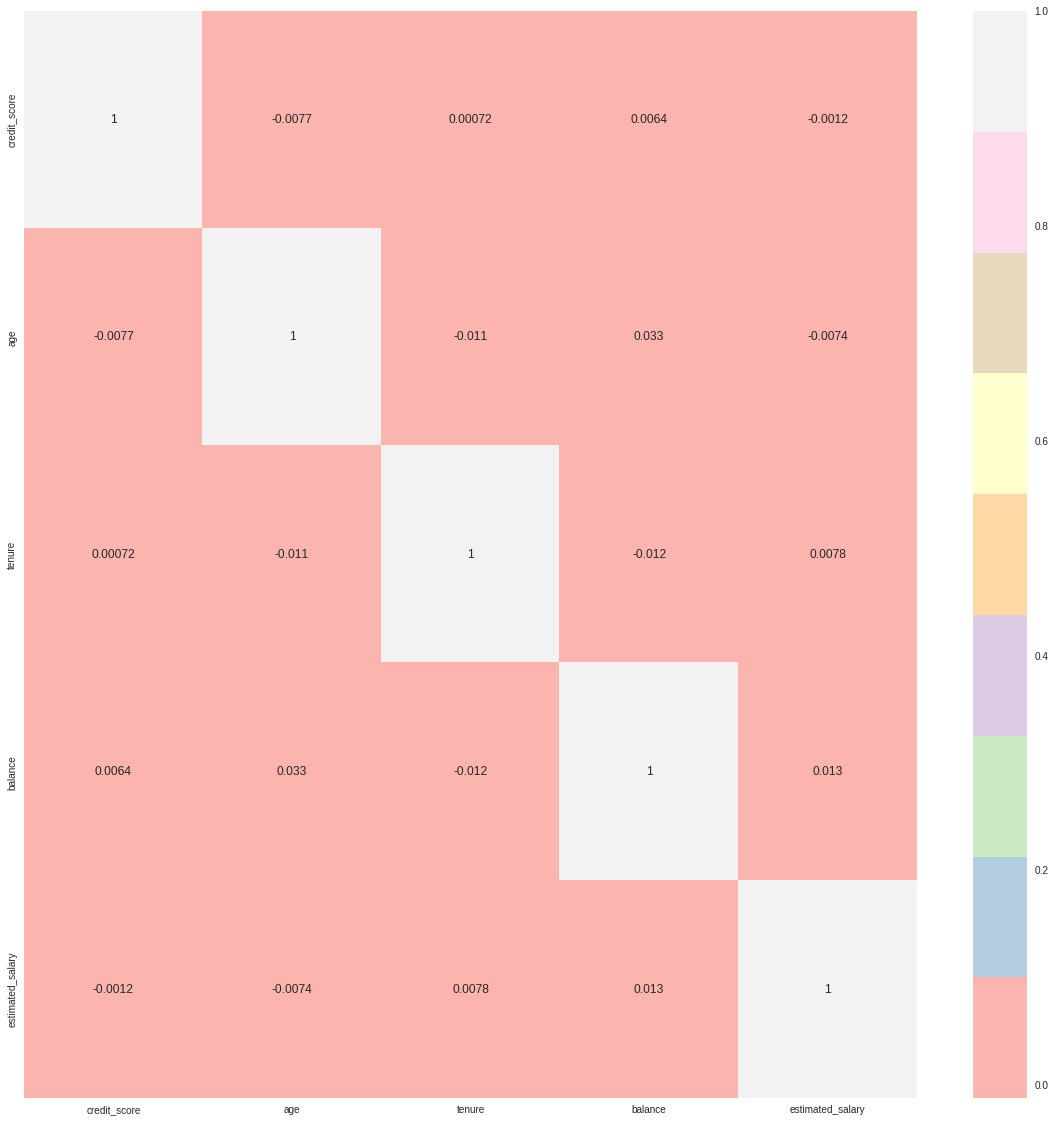

In [15]:
# heatmap of correlations

corrmat = df[df.columns[~df.columns.isin(['active_member','products_number','credit_card','churn'])]].corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="Pastel1")
plt.savefig('Heatmap churn.png')

In [16]:
# One-hot encoding categorical columns
#cleanup_cat = {"churn":{"no": 0, "yes": 1}, "international_plan":{"no": 0, "yes": 1},"voice_mail_plan":{"no": 0, "yes": 1}}
#df = df.replace(cleanup_cat)
df = pd.get_dummies(data = df,columns = ["country", "gender"] )

In [17]:
df.head()

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,country_France,country_Germany,country_Spain,gender_Female,gender_Male
0,619.0,42.0,2,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,608.0,41.0,1,83807.86,1,0,1,112542.58,0,0,0,1,1,0
2,502.0,42.0,8,159660.80,3,1,0,113931.57,1,1,0,0,1,0
3,699.0,39.0,1,0.00,2,0,0,93826.63,0,1,0,0,1,0
4,850.0,43.0,2,125510.82,1,1,1,79084.10,0,0,0,1,1,0


In [18]:
cat_columns = ["products_number","credit_card","active_member","country_France","country_Germany","country_Spain","gender_Female","gender_Male"]
res = sklearn.feature_selection.chi2(df[cat_columns], df["churn"])
res_chi2_tests = pd.DataFrame(list(zip(cat_columns,list(res[0]), list(res[1]))), columns = ['variable','chi2','p_value'])
res_chi2_tests.sort_values('chi2',ascending = False)

,variable,chi2,p_value
4,country_Germany,225.464426,5.814572e-51
2,active_member,118.199414,1.568036e-27
6,gender_Female,61.909174,3.596700e-15
3,country_France,54.923705,1.253006e-13
7,gender_Male,51.539926,7.015575e-13
5,country_Spain,20.867206,4.922505e-06
0,products_number,5.055394,2.454940e-02
1,credit_card,0.150041,6.984962e-01


In [19]:
num_columns = ['credit_score', 'age', 'tenure', 'balance', 'estimated_salary']
res = sklearn.feature_selection.f_classif(df[cat_columns], df["churn"])
res_anova_tests = pd.DataFrame(list(zip(num_columns,list(res[0]), list(res[1]))), columns = ['variable','F-value','p_value'])
res_anova_tests.sort_values('F-value',ascending = False)

,variable,F-value,p_value
4,estimated_salary,310.258384,2.059537e-68
2,tenure,249.800794,1.348269e-55
3,balance,111.360517,6.748446e-26
0,credit_score,22.915223,1.717333e-06
1,age,0.509401,4.754149e-01


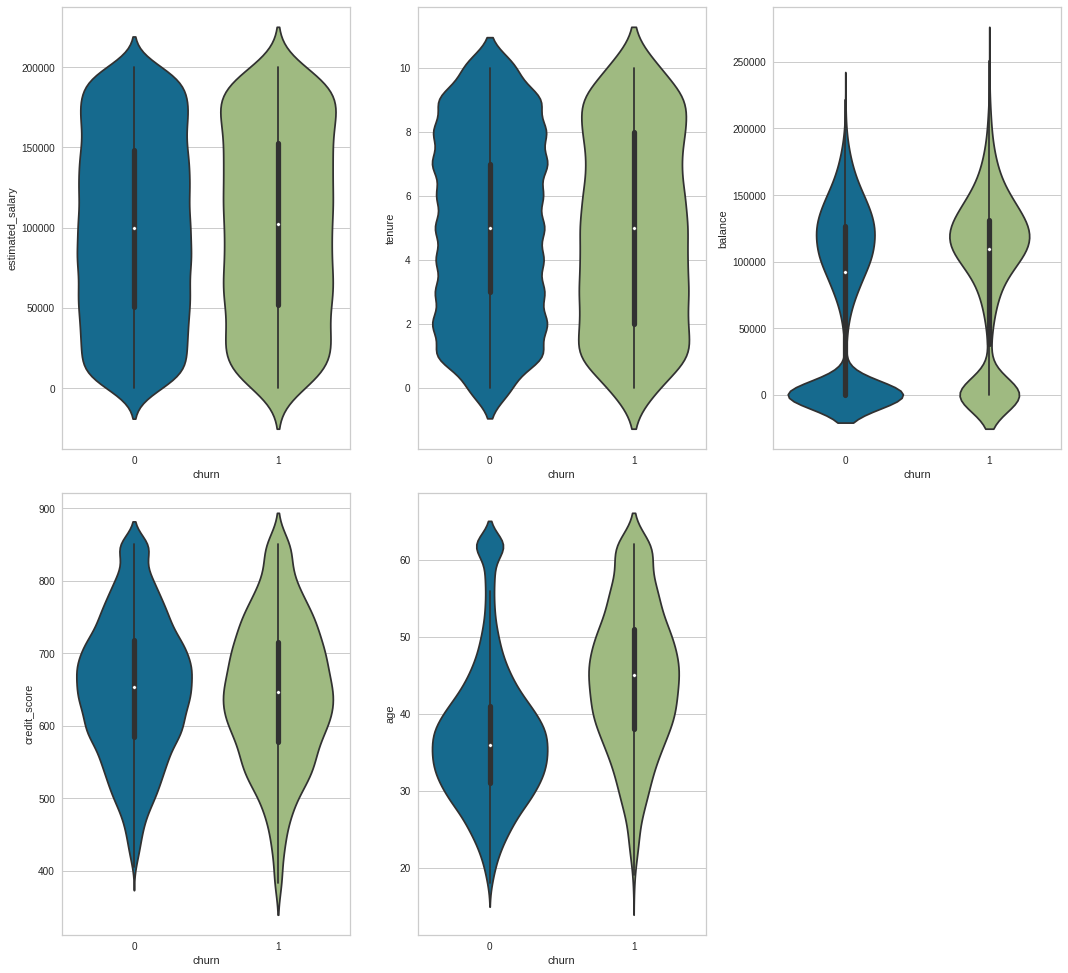

In [20]:
fig = plt.figure(figsize = (15,20))


plt.subplot(3, 3, 1)
sns.violinplot(data = df, x="churn", y="estimated_salary")
plt.subplot(3, 3, 2)
sns.violinplot(data = df, x="churn", y="tenure")
plt.subplot(3, 3, 3)
sns.violinplot(data = df, x="churn", y="balance")
plt.subplot(3, 3, 4)
sns.violinplot(data = df, x="churn", y="credit_score")
plt.subplot(3, 3, 5)
sns.violinplot(data = df, x="churn", y="age")

plt.tight_layout()

plt.show()

# Model building

In [21]:
y = df['churn']
X = df.drop('churn', axis=1)

# In the first step we will split the data in training and remaining dataset
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.7, random_state=None, shuffle = True)

# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)
test_size = 0.5
X_val, X_test, y_val, y_test = train_test_split(X_rem,y_rem, test_size=2/3, random_state=None, shuffle = True)

# smote dataset
smote = SMOTE(random_state = 1)

X_train_s, y_train_s = smote.fit_resample(X_train, y_train)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(X_train_s.shape)


(7000, 13)
(1000, 13)
(2000, 13)
(11194, 13)


In [22]:
pd.DataFrame(y_train_s).groupby('churn').size()

churn
0    5597
1    5597
dtype: int64

In [23]:
pd.DataFrame(y_train).groupby('churn').size()

churn
0    5597
1    1403
dtype: int64

In [24]:
pd.DataFrame(y_val).groupby('churn').size()

churn
0    798
1    202
dtype: int64

In [25]:
pd.DataFrame(y_test).groupby('churn').size()

churn
0    1568
1     432
dtype: int64

In [30]:
# Standardization of the dataset

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

X_train_s = scaler.fit_transform(X_train_s)



In [31]:
# Feature selection

log = LogisticRegression()
rfe = RFE(log,n_features_to_select=10, step=1)
rfe = rfe.fit(X_train,y_train.values.ravel())
#identified columns Recursive Feature Elimination
idc_rfe = pd.DataFrame({"rfe_support" :rfe.support_,
                       "columns" : [i for i in df.columns if i not in "churn"],
                       "ranking" : rfe.ranking_
                      })
cols = idc_rfe[idc_rfe["rfe_support"] == True]["columns"].tolist()
print(cols)

['credit_score', 'age', 'balance', 'active_member', 'estimated_salary', 'country_France', 'country_Germany', 'country_Spain', 'gender_Female', 'gender_Male']


In [32]:
# We prepare the data to build models with the selected features
cols = ['credit_score', 'age', 'balance', 'products_number', 'active_member', 'country_France', 'country_Germany', 'country_Spain', 'gender_Female', 'gender_Male']
X = X[cols]
# In the first step we will split the data in training and remaining dataset
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.7,stratify=y, random_state=0)

# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)
test_size = 0.5
X_val, X_test, y_val, y_test = train_test_split(X_rem,y_rem, test_size=2/3,stratify=y_rem, random_state=0)

# smote dataset
smote = SMOTE(random_state = 1)

X_train_s, y_train_s = smote.fit_resample(X_train, y_train)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(X_train_s.shape)


(7000, 10)
(1000, 10)
(2000, 10)
(11148, 10)


In [33]:
master_eval_dict = {}
master_eval_dict_s = {}
eval_metrics = ["accuracy", "precision", "recall", "f1"]

#to zip all results together
def eval_scores(y_test,y_predict):

    eval_scores = list()

    eval_scores.append(metrics.accuracy_score(y_test,y_predict)*100)
    eval_scores.append(metrics.precision_score(y_test,y_predict)*100)
    eval_scores.append(metrics.recall_score(y_test,y_predict)*100)
    eval_scores.append(metrics.f1_score(y_test,y_predict)*100)

    metrics_dict = dict(zip(eval_metrics, eval_scores))

    return metrics_dict

**Logistic regression**

In [34]:
#find optimum hyperparameters for Logistic Regression 
log_reg = LogisticRegression(solver='liblinear')
param_grid = { "penalty" : ["l1", "l2"],
         "C" : np.arange(60,80,2)}


In [35]:

log_reg_gscv = GridSearchCV(estimator=log_reg, param_grid=param_grid ,cv=5) #Kfold value for cross validation is 5
log_reg_gscv.fit(X_train, y_train)#to fit training data
print("Tuned hyperparameters for Logistic Regression:",log_reg_gscv.best_params_) 

Tuned hyperparameters for Logistic Regression: {'C': 70, 'penalty': 'l1'}


In [36]:
log_reg_gscv_s = GridSearchCV(estimator=log_reg, param_grid=param_grid ,cv=5) #Kfold value for cross validation is 5
log_reg_gscv_s.fit(X_train_s, y_train_s)#to fit training data
print("Tuned hyperparameters for Logistic Regression:",log_reg_gscv_s.best_params_) 

Tuned hyperparameters for Logistic Regression: {'C': 78, 'penalty': 'l1'}


In [37]:
#Tuned hyperparameters to test on validation set 
log_reg = LogisticRegression(solver='liblinear', **log_reg_gscv.best_params_)
log_reg.fit(X_train, y_train)
y_predict_val = log_reg.predict(X_val) #prediction on validation 


In [38]:
#Tuned hyperparameters to test on validation set 
log_reg_s = LogisticRegression(solver='liblinear', **log_reg_gscv_s.best_params_)
log_reg_s.fit(X_train_s, y_train_s)
y_predict_val_s = log_reg_s.predict(X_val) #prediction on validation 


In [39]:
master_eval_dict.update({"Log Reg": eval_scores(y_val,y_predict_val)})
master_eval_dict_s.update({"Log Reg": eval_scores(y_val,y_predict_val_s)})

**Support vector classifier**

In [40]:
#Report which parameter gives best result under the grid search procedure for Support Vector Classifier
svc=svm.SVC(probability=True)
#param_grid = [ {'C':[1, 10], 'kernel':['rbf'], 'gamma':[0.1, 1, 10, 100]} ]
param_grid1 = [ {'C':[1], 'kernel':['rbf'], 'gamma':[1]} ]
param_grid2 = [ {'C':[10], 'kernel':['rbf'], 'gamma':[0.1]} ]

In [41]:
# Create a classifier object with the classifier and parameter candidates
svc_gscv = GridSearchCV(svc, param_grid=param_grid1,cv=5) #Kfold is 5 
svc_gscv.fit(X_train, y_train) #fit training data
print("Tuned hyperparameters for svc:",svc_gscv.best_params_) 

Tuned hyperparameters for svc: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}


In [42]:
# Create a classifier object with the classifier and parameter candidates
svc_gscv_s = GridSearchCV(svc, param_grid=param_grid2,cv=5) #Kfold is 5 
svc_gscv_s.fit(X_train_s, y_train_s) #fit training data
print("Tuned hyperparameters for svc:",svc_gscv_s.best_params_) 

Tuned hyperparameters for svc: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


In [43]:
#Tuned hyperparameters to test on validation set 
svc= svm.SVC(**svc_gscv.best_params_,probability=True)
svc.fit(X_train, y_train)#fit training data with optimal parameters
svc_y_predict_val = svc.predict(X_val) #prediction on validation 


In [44]:
#Tuned hyperparameters to test on validation set 
svc_s= svm.SVC(**svc_gscv_s.best_params_,probability=True)
svc_s.fit(X_train, y_train)#fit training data with optimal parameters
svc_y_predict_val_s = svc.predict(X_val) #prediction on validation 

In [45]:
master_eval_dict.update({"SVC": eval_scores(y_val,svc_y_predict_val)})
master_eval_dict_s.update({"SVC": eval_scores(y_val,svc_y_predict_val_s)})

**Random forest classifier**

In [46]:
rf = sklearn.ensemble.RandomForestClassifier()  
#param_grid = { "n_estimators" : [10, 100,1000],  
#           "max_depth" : [5, 100,500],  
#           "min_samples_leaf" : [1, 20,40],  
#           "max_features" : ['auto', 'sqrt', 'log2']}

param_grid1 = { "n_estimators" : [1000],  
           "max_depth" : [500],  
           "min_samples_leaf" : [20],  
           "max_features" : ['log2']}
param_grid2 = { "n_estimators" : [1000],  
           "max_depth" : [100],  
           "min_samples_leaf" : [1],  
           "max_features" : ['auto']}

In [47]:
rf_gscv = GridSearchCV(estimator=rf, param_grid=param_grid1 ,cv=5) #number of Kfolds=5
rf_gscv.fit(X_train, y_train)#fit training data
print("Tuned hyperparameters:",rf_gscv.best_params_) 


Tuned hyperparameters: {'max_depth': 500, 'max_features': 'log2', 'min_samples_leaf': 20, 'n_estimators': 1000}


In [48]:
rf_gscv_s = GridSearchCV(estimator=rf, param_grid=param_grid2 ,cv=5) #number of Kfolds=5
rf_gscv_s.fit(X_train_s, y_train_s)#fit training data
print("Tuned hyperparameters:",rf_gscv_s.best_params_) 

Tuned hyperparameters: {'max_depth': 100, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 1000}


In [49]:
#Fitting the classifier with the parameters that yielded the best score in the grid search

rf = RandomForestClassifier(**rf_gscv.best_params_)
#  fit on train data with tuned hyperparameters
rf.fit(X_train, y_train)
rf_y_predict_val = rf.predict(X_val) #prediction on validation set


In [50]:
#Fitting the classifier with the parameters that yielded the best score in the grid search

rf_s = RandomForestClassifier(**rf_gscv_s.best_params_)
#  fit on train data with tuned hyperparameters
rf_s.fit(X_train_s, y_train_s)
rf_y_predict_val_s = rf_s.predict(X_val) #prediction on validation set

In [51]:
master_eval_dict.update({"RF": eval_scores(y_val,rf_y_predict_val)})
master_eval_dict_s.update({"RF": eval_scores(y_val,rf_y_predict_val_s)})

**KNN classifier**

In [52]:
#Report which parameter gives best result under the grid search 
knn = KNeighborsClassifier()
#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 50)}


In [53]:
#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn, param_grid, cv=5)
#fit model to data
knn_gscv.fit( X_train, y_train)
print("Tuned hyperparameter:",knn_gscv.best_params_)


Tuned hyperparameter: {'n_neighbors': 44}


In [54]:
#use gridsearch to test all values for n_neighbors
knn_gscv_s = GridSearchCV(knn, param_grid, cv=5)
#fit model to data
knn_gscv_s.fit( X_train_s, y_train_s)
print("Tuned hyperparameter:",knn_gscv_s.best_params_)


Tuned hyperparameter: {'n_neighbors': 1}


In [55]:
#Tuned hyperparameters to test on validation set 
knn = KNeighborsClassifier(**knn_gscv.best_params_)
knn.fit(X_train, y_train)#to fit training set with optimal  parameters 
knn_y_predict_val = knn.predict(X_val) #prediction on validation 


In [56]:
#Tuned hyperparameters to test on validation set 
knn = KNeighborsClassifier(**knn_gscv_s.best_params_)
knn.fit(X_train_s, y_train_s)#to fit training set with optimal  parameters 
knn_y_predict_val_s = knn.predict(X_val) #prediction on validation 


In [57]:
master_eval_dict.update({"KNN": eval_scores(y_val,knn_y_predict_val)})
master_eval_dict_s.update({"KNN": eval_scores(y_val,knn_y_predict_val_s)})

**SGD classifier**

In [58]:
SGDC = SGDClassifier(max_iter=1000)

param_grid = {
    "loss" : ["hinge", "log", "squared_hinge", "modified_huber"],
    "alpha" : [0.0001, 0.001, 0.01, 0.1],
    "penalty" : ["l2", "l1", "none"],
}

In [59]:
SGDC_gscv = GridSearchCV(SGDC, param_grid, cv=5)
#fit model to data
SGDC_gscv.fit(X_train, y_train)
#check top performing n_neighbors value
print("Tuned hyperparameters : ",SGDC_gscv.best_params_)


Tuned hyperparameters :  {'alpha': 0.1, 'loss': 'hinge', 'penalty': 'l2'}


In [60]:
SGDC_gscv_s = GridSearchCV(SGDC, param_grid, cv=5)
#fit model to data
SGDC_gscv_s.fit(X_train_s, y_train_s)
#check top performing n_neighbors value
print("Tuned hyperparameters : ",SGDC_gscv_s.best_params_)


Tuned hyperparameters :  {'alpha': 0.1, 'loss': 'hinge', 'penalty': 'l1'}


In [61]:
#Tuned hyperparameters to test on validation set 
SGDC = SGDClassifier(**SGDC_gscv.best_params_)
SGDC.fit(X_train, y_train)#to fit training set with optimal  parameters 
SGDC_y_predict_val = SGDC.predict(X_val) #prediction on validation 


In [62]:
#Tuned hyperparameters to test on validation set 
SGDC_s = SGDClassifier(**SGDC_gscv_s.best_params_)
SGDC_s.fit(X_train_s, y_train_s)#to fit training set with optimal  parameters 
SGDC_y_predict_val_s = SGDC.predict(X_val) #prediction on validation 


In [63]:
master_eval_dict.update({"SGDC": eval_scores(y_val,SGDC_y_predict_val)})
master_eval_dict_s.update({"SGDC": eval_scores(y_val,SGDC_y_predict_val_s)})

**Gaussian Naive Bayes**

In [64]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)


GaussianNB()

In [65]:
gnb_s = GaussianNB()
gnb_s.fit(X_train_s, y_train_s)


GaussianNB()

In [66]:
gnb_y_predict_val = gnb.predict(X_val) #prediction on validation 
gnb_y_predict_val_s = gnb_s.predict(X_val) #prediction on validation 


In [67]:
master_eval_dict.update({"GNB": eval_scores(y_val,gnb_y_predict_val)})
master_eval_dict_s.update({"GNB": eval_scores(y_val,gnb_y_predict_val_s)})

In [68]:
pd.DataFrame(master_eval_dict)

,Log Reg,SVC,RF,KNN,SGDC,GNB
accuracy,81.900000,79.6,85.900000,79.6,76.200000,78.600000
precision,64.935065,0.0,81.188119,0.0,26.388889,42.857143
recall,24.509804,0.0,40.196078,0.0,9.313725,14.705882
f1,35.587189,0.0,53.770492,0.0,13.768116,21.897810


In [69]:
pd.DataFrame(master_eval_dict_s)

,Log Reg,SVC,RF,KNN,SGDC,GNB
accuracy,80.000000,79.6,85.500000,64.100000,76.200000,69.600000
precision,51.265823,0.0,67.251462,25.080386,26.388889,36.486486
recall,39.705882,0.0,56.372549,38.235294,9.313725,66.176471
f1,44.751381,0.0,61.333333,30.291262,13.768116,47.038328


In [70]:
rf_y_predict_test_s = rf_s.predict(X_test) #prediction on test set
rf_y_proba_test_s = rf_s.predict_proba(X_test)[:,1] #probalities on test set
print(classification_report(y_test,rf_y_predict_test_s))

              precision    recall  f1-score   support

           0       0.89      0.92      0.90      1593
           1       0.64      0.56      0.59       407

    accuracy                           0.85      2000
   macro avg       0.76      0.74      0.75      2000
weighted avg       0.84      0.85      0.84      2000



In [71]:
rf_y_proba_test_s

array([0.082, 0.151, 0.567, ..., 0.005, 0.057, 0.004])

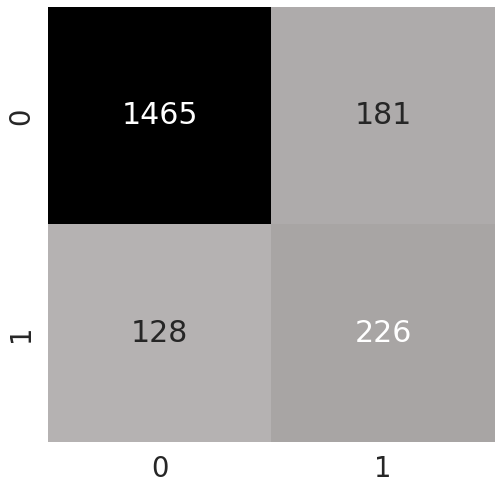

In [72]:
#confusion matrix
conf_matrix = confusion_matrix(rf_y_predict_test_s,y_test)
plt.figure(figsize=(8,8))
cmap = sns.cubehelix_palette(50,hue=0.05,rot=-1,light=0.7,dark=0,as_cmap=True)
sns.set(font_scale=2.5)
sns.heatmap(conf_matrix,annot=True,cbar=False,cmap=cmap,fmt="d")
plt.show()

In [73]:
#roc_auc_score
model_roc_auc = roc_auc_score(rf_y_predict_test_s,y_test) 
print ("Area under curve : ",model_roc_auc,"\n")
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, rf_y_proba_test_s)

Area under curve :  0.7642272655504527 



In [74]:
#plot roc curve
trace2 = go.Scatter(x = false_positive_rate1,y = true_positive_rate1,
                    name = "Roc : " + str(model_roc_auc),
                    line = dict(color = ('rgb(22, 96, 167)'),width = 2))
trace3 = go.Scatter(x = [0,1],y=[0,1],
                    line = dict(color = ('rgb(205, 12, 24)'),width = 2,
                    dash = 'dot'))

data = [trace2,trace3]

layout = go.Layout(dict(title = "Receiver operating characteristic",
                        autosize = False,
                        height = 700,width = 800,
                        plot_bgcolor = 'rgba(240,240,240, 0.95)',
                        paper_bgcolor = 'rgba(240,240,240, 0.95)',
                        margin = dict(b = 195),
                        xaxis = dict(title = "false positive rate"),
                        yaxis = dict(title = "true positive rate"),
                       )
                  )
# fig['layout'].update(showlegend=False, title="Receiver operating characteristic" ,
#                          autosize = True,
#                          plot_bgcolor = 'rgba(240,240,240, 0.95)',
#                          paper_bgcolor = 'rgba(240,240,240, 0.95)',
#                          margin = dict(b = 195))
# fig["layout"]["xaxis"].update(dict(title = "false positive rate"))
# fig["layout"]["yaxis"].update(dict(title = "true positive rate"))
#defining figure and plotting
fig = go.Figure(data,layout=layout)
iplot(fig)

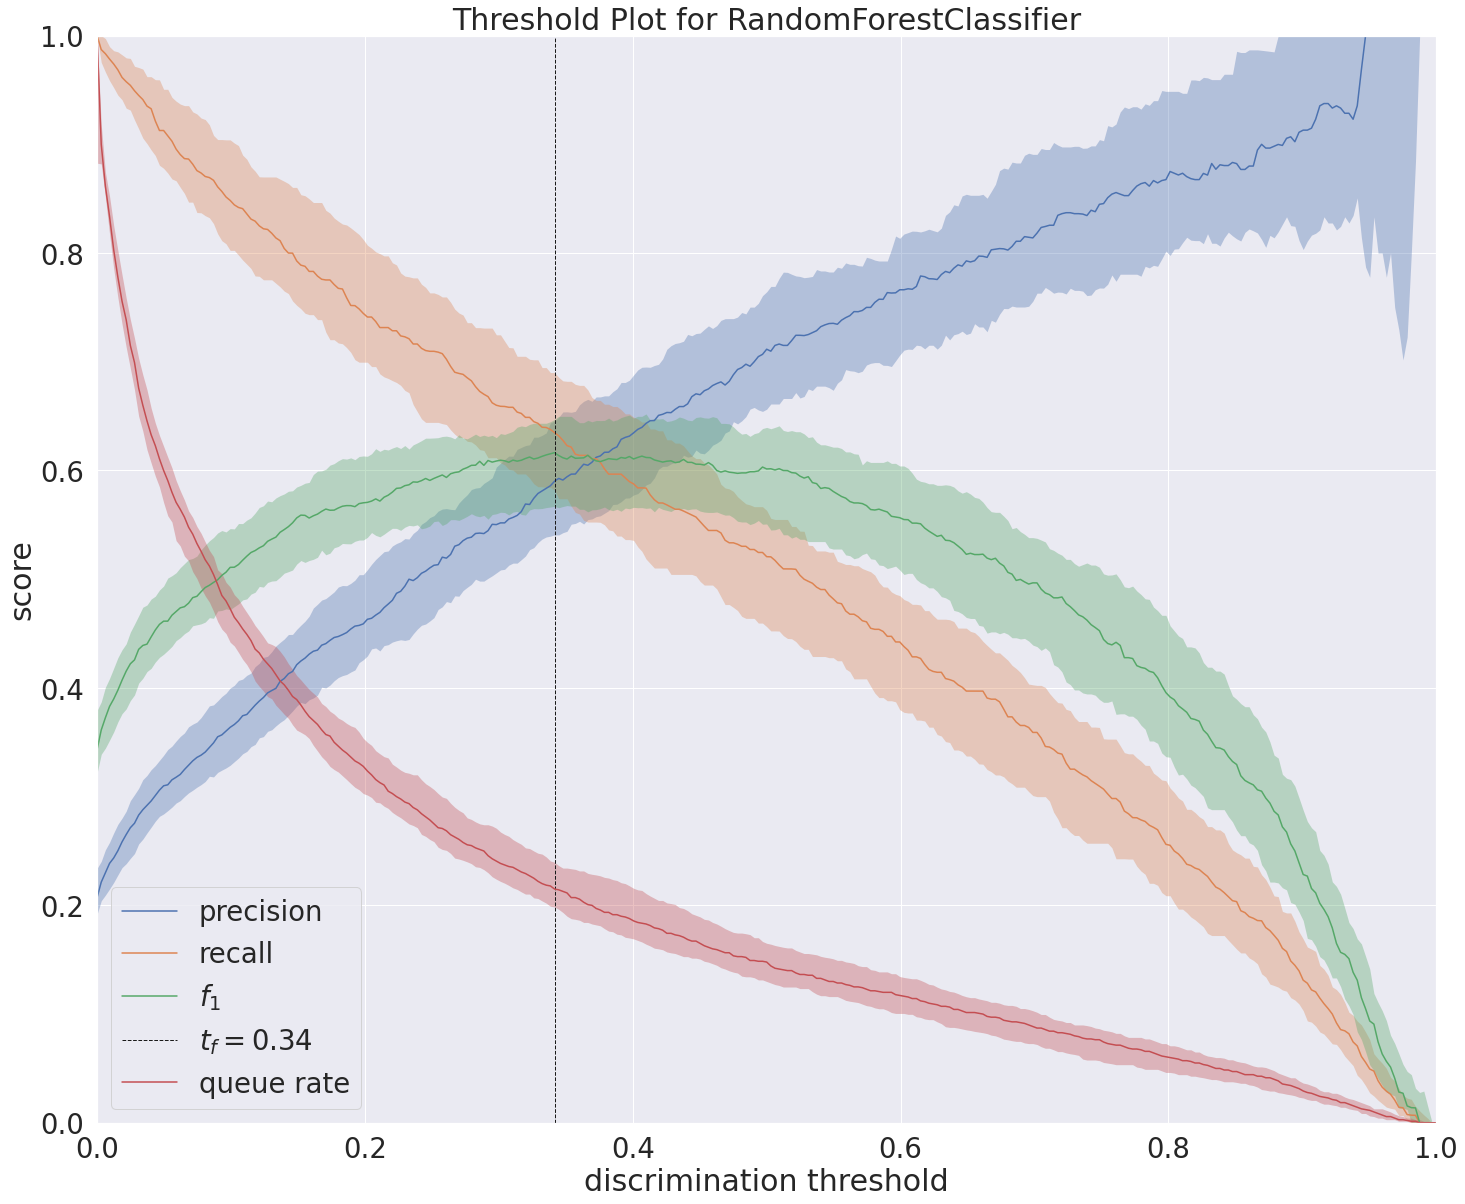

In [75]:
plt.figure(figsize=(24,20))
visualizer = DiscriminationThreshold(rf_s)
visualizer.fit(X_train,y_train)
visualizer.poof()
plt.show()

In [76]:
# saving the model 

# save the model to disk
filename = 'finalized_model.pkl'
pickle.dump(rf_s, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.8455
